# Financial Stock analysis

Step 1 : Import required libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import nltk
from textblob import TextBlob
import re
from nltk.corpus import stopwords
nltk.download('stopwords')  # Run once

import warnings
warnings.filterwarnings('ignore')

# Download NLTK data (run once)
nltk.download('punkt', quiet=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hello\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Step 2: Load the dataset the CSV format

In [3]:
try:
    df = pd.read_csv('../data/raw_analyst_ratings.csv')
    unnamed_cols = df.columns[df.columns.str.contains('Unnamed', case=False)]
    df = df.drop(columns=unnamed_cols, axis=1)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("❌ Data file not found. Please ensure the CSV file is in the data/ folder")
    df = pd.DataFrame()

print("\n📊 Dataset Info:")
print(df.info())
print(f"Dataset shape: {df.shape}")
print("\nDataset columns:")
print(df.columns.tolist())

print("\n🔍 First 5 rows:")
display(df.head())


Dataset loaded successfully!

📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   date       1407328 non-null  object
 4   stock      1407328 non-null  object
dtypes: object(5)
memory usage: 53.7+ MB
None
Dataset shape: (1407328, 5)

Dataset columns:
['headline', 'url', 'publisher', 'date', 'stock']

🔍 First 5 rows:


,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


Step 3: Perform Descriptive Statistics

In [4]:
# ==================== DESCRIPTIVE STATISTICS ====================
print("Original date column dtype:", df['date'].dtype)
print("Sample dates:\n", df['date'].head())

# Convert 'date' column to datetime (with UTC-4 timezone as specified in the dataset)
# The format in FNSPID is like: "2020-06-05 09:31:00-04:00"
df['date'] = pd.to_datetime(df['date'],format='ISO8601', utc=True)  # Handles timezone properly
# Now extract components safely
df['publication_date'] = df['date'].dt.date
df['publication_day']   = df['date'].dt.day_name()
df['publication_hour']  = df['date'].dt.hour
df['publication_month'] = df['date'].dt.month
df['publication_year']  = df['date'].dt.year

print(f"Date parsing successful! Column is now: {df['date'].dtype}")
print(f"Date range: {df['date'].min()} → {df['date'].max()}")
print(f"Total unique trading days: {df['publication_date'].nunique()}\n")


Original date column dtype: object
Sample dates:
 0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
3    2020-05-22 12:45:06-04:00
4    2020-05-22 11:38:59-04:00
Name: date, dtype: object
Date parsing successful! Column is now: datetime64[ns, UTC]
Date range: 2009-02-14 04:00:00+00:00 → 2020-06-11 21:12:35+00:00
Total unique trading days: 3955



=== Headline Length Statistics ===
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


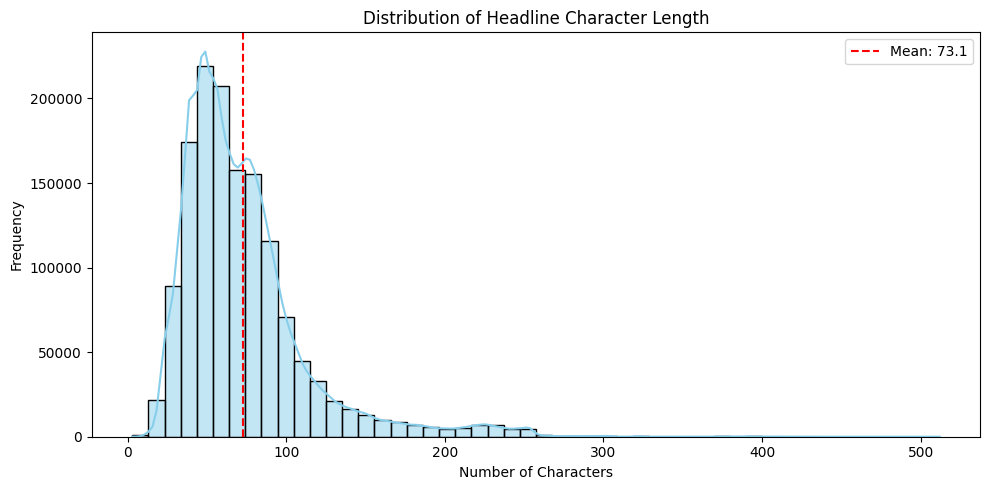

In [5]:
# --------------------------------------------------
# 1. Headline length analysis
df['headline_length'] = df['headline'].str.len()

print("=== Headline Length Statistics ===")
print(df['headline_length'].describe())

# Plot: Distribution of headline lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['headline_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Headline Character Length')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.axvline(df['headline_length'].mean(), color='red', linestyle='--', label=f"Mean: {df['headline_length'].mean():.1f}")
plt.legend()
plt.tight_layout()
# plt.savefig('notebooks/headline_length_distribution.png', dpi=300)
plt.show()

# --------------------------------------------------


Total number of unique publishers: 1034

Top 10 most active publishers:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


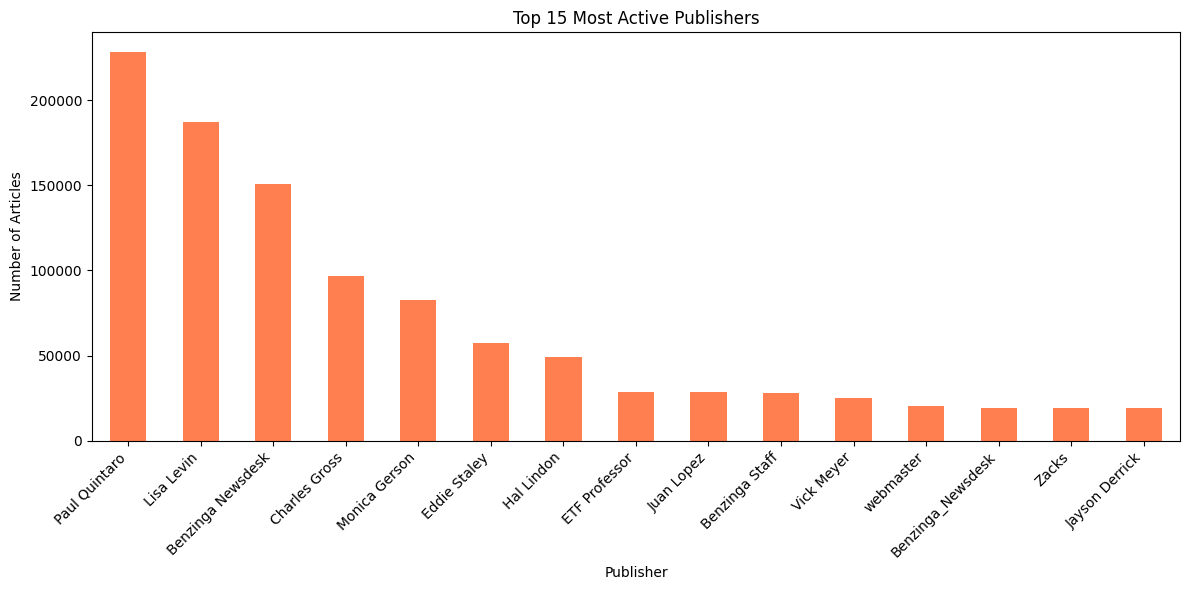

In [6]:

# --------------------------------------------------
# 2. Articles per publisher
publisher_counts = df['publisher'].value_counts()

print(f"\nTotal number of unique publishers: {len(publisher_counts)}")
print("\nTop 10 most active publishers:")
print(publisher_counts.head(10))

# Plot: Top publishers
plt.figure(figsize=(12, 6))
top_n = 15
publisher_counts.head(top_n).plot(kind='bar', color='coral')
plt.title(f'Top {top_n} Most Active Publishers')
plt.ylabel('Number of Articles')
plt.xlabel('Publisher')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Publication date & time analysis


Publication Date Range: 2009-02-14 04:00:00+00:00 → 2020-06-11 21:12:35+00:00
Total days with news: 3955


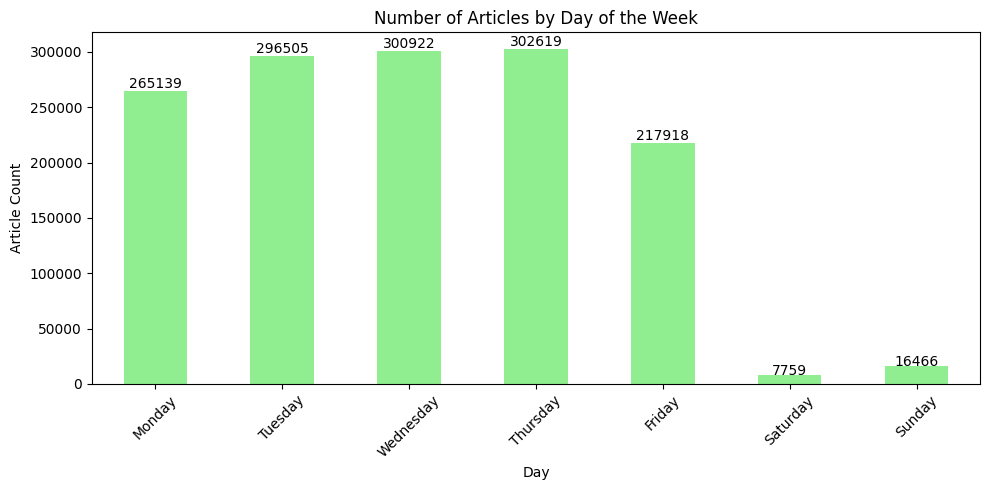

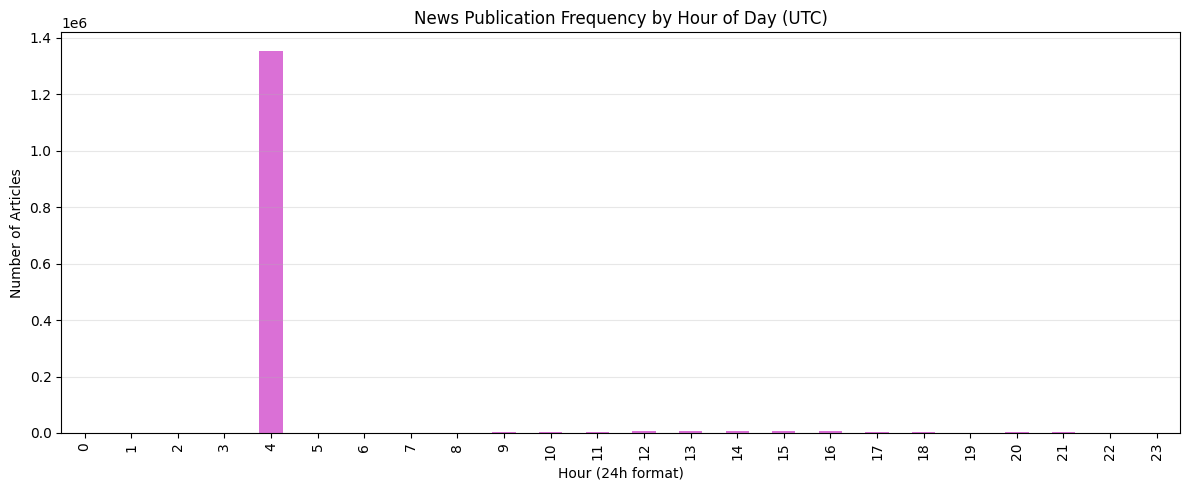


Peak publishing hours (UTC):
publication_hour
4     1351408
14       7669
13       5965
16       5732
15       5701
Name: count, dtype: int64


In [7]:

print(f"\nPublication Date Range: {df['date'].min()} → {df['date'].max()}")
print(f"Total days with news: {df['publication_date'].nunique()}")

# Articles per day of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
articles_by_day = df['publication_day'].value_counts().reindex(day_order, fill_value=0)

plt.figure(figsize=(10, 5))
articles_by_day.plot(kind='bar', color='lightgreen')
plt.title('Number of Articles by Day of the Week')
plt.ylabel('Article Count')
plt.xlabel('Day')
plt.xticks(rotation=45)
for i, v in enumerate(articles_by_day):
    plt.text(i, v + v*0.01, str(v), ha='center')
plt.tight_layout()
# plt.savefig('notebooks/articles_by_day_of_week.png', dpi=300)
plt.show()

# Articles by hour (reveals market timing patterns!)
hour_counts = df['publication_hour'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
hour_counts.plot(kind='bar', color='orchid')
plt.title('News Publication Frequency by Hour of Day (UTC)')
plt.xlabel('Hour (24h format)')
plt.ylabel('Number of Articles')
plt.xticks(range(0, 24), range(0, 24))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
# plt.savefig('notebooks/publication_by_hour.png', dpi=300)
plt.show()

# Peak publishing hours
peak_hours = hour_counts.sort_values(ascending=False).head(5)
print("\nPeak publishing hours (UTC):")
print(peak_hours)

 Step 4: Text Analysis and Topic Modeling

TEXT ANALYSIS WITH STOP WORDS FILTERING
Pre-defined financial keyword frequency in headlines:
• FDA                 : 11382 occurrences
• FED                 : 10030 occurrences
• price target        : 47634 occurrences
• earnings            : 86626 occurrences
• stock               : 202861 occurrences
• profit              : 12195 occurrences
• approval            : 5880 occurrences
• surge               : 8419 occurrences
• drop                : 8985 occurrences
• growth              : 13842 occurrences
• revenue             : 39695 occurrences
• dividend            : 21572 occurrences
• merger              : 5621 occurrences
• acquisition         : 8911 occurrences
• bullish             : 3677 occurrences
• bearish             : 1272 occurrences
• volatility          : 2230 occurrences
• inflation           : 1061 occurrences
• interest rates      : 743 occurrences
• quarterly           : 3688 occurrences
• annual              : 2786 occurrences

-----------------------------------

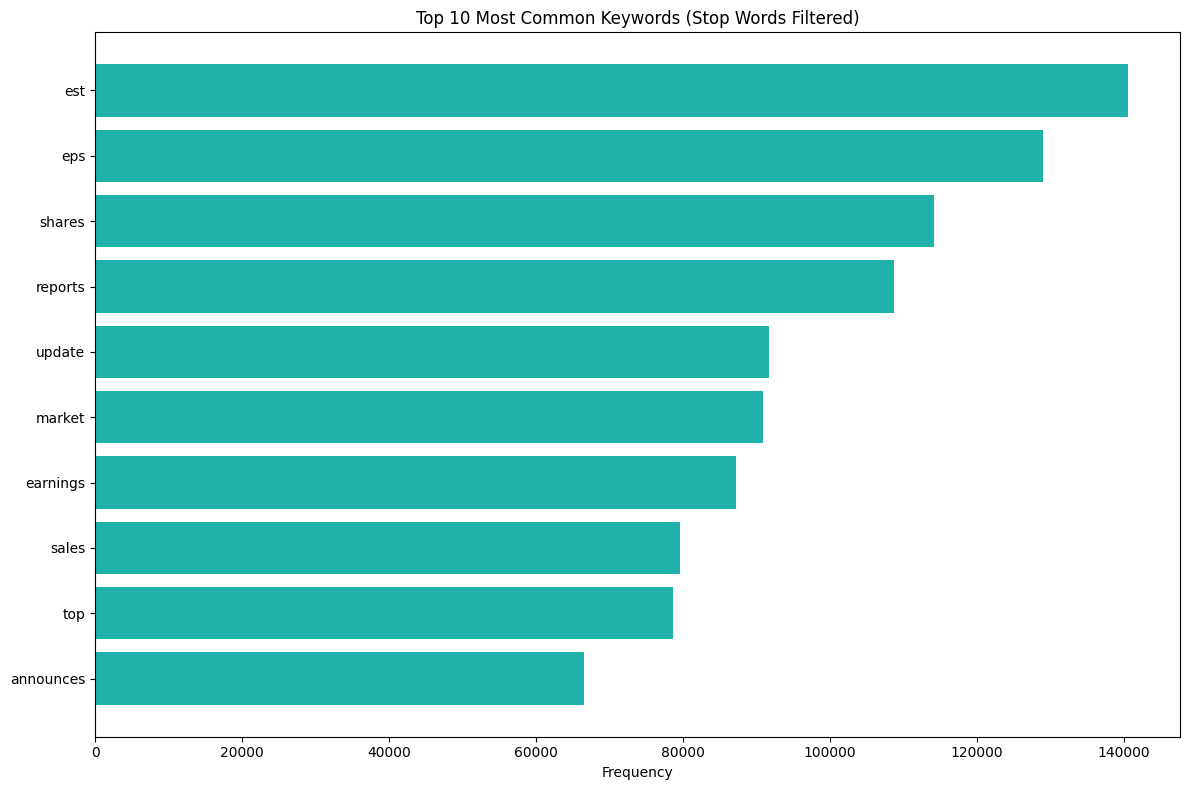

In [8]:
from collections import Counter
import string

# Download stopwords if not already available
nltk.download('stopwords', quiet=True)

## 1. Enhanced keyword analysis with stop words filtering
print("=" * 50)
print("TEXT ANALYSIS WITH STOP WORDS FILTERING")
print("=" * 50)

# Method 1: Pre-defined important financial keywords
financial_keywords = ['FDA', 'FED', 'price target', 'earnings', 'stock', 'profit', 
                     'approval', 'surge', 'drop', 'growth', 'revenue', 'dividend',
                     'merger', 'acquisition', 'bullish', 'bearish', 'volatility',
                     'inflation', 'interest rates', 'quarterly', 'annual']

print("Pre-defined financial keyword frequency in headlines:")
keyword_results = {}
for keyword in financial_keywords:
    count = df['headline'].str.contains(keyword, case=False, na=False).sum()
    keyword_results[keyword] = count
    print(f"• {keyword:<20}: {count:>3} occurrences")

# Method 2: Automated common words extraction with stop words filtering
print("\n" + "-" * 50)
print("AUTOMATED KEYWORD EXTRACTION (Stop Words Filtered)")
print("-" * 50)

# Get English stop words
stop_words = set(stopwords.words('english'))

# Add custom financial stop words that are too common but not meaningful
financial_stop_words = {'said', 'inc', 'corp', 'ltd', 'nyse', 'nasdaq', 'stock', 'stocks'}
stop_words.update(financial_stop_words)

# Process all headlines
all_words = ' '.join(df['headline'].astype(str)).lower()

# Remove punctuation and split into words
translator = str.maketrans('', '', string.punctuation)
all_words_clean = all_words.translate(translator)
words_list = all_words_clean.split()

# Filter out stop words and short words (length < 3)
filtered_words = [word for word in words_list 
                 if word not in stop_words and len(word) > 2 and word.isalpha()]

# Count word frequency
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(15)

print("Most common meaningful keywords (stop words filtered):")
for i, (word, count) in enumerate(common_words, 1):
    print(f"{i:2d}. {word:<15} : {count:>3} occurrences")

## 3. Enhanced common phrases extraction with filtering
def extract_filtered_phrases(texts, min_count=2):
    all_phrases = []
    for text in texts:
        try:
            blob = TextBlob(str(text))
            phrases = blob.noun_phrases
            # Filter out phrases that contain mostly stop words
            filtered_phrases = [
                phrase for phrase in phrases 
                if not all(word in stop_words for word in phrase.split())
                and len(phrase) > 3  # Minimum phrase length
            ]
            all_phrases.extend(filtered_phrases)
        except:
            continue
    
    phrase_counts = pd.Series(all_phrases).value_counts()
    return phrase_counts[phrase_counts >= min_count]

# top_keywords = [word for word, _ in common_words[:5]]  # Top 5 automated keywords

## 6. Visualization of common keywords
plt.figure(figsize=(12, 8))
words, counts = zip(*common_words[:10])
plt.barh(words, counts, color='lightseagreen')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Keywords (Stop Words Filtered)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Step 5: Time Series Analysis

 Step 6: Publisher Analysis